# **LIBRARY PREPARATION**

In [2]:
# 1. Import necessary libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
# from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

# **DIG DATA PREPARATION**

In [3]:
# 8:2 ratio
df = pd.read_csv('DIG Historical Data 2018.csv') # Read data
df = df[['Price']]
df = df.dropna() # Drop NaN values
df = df[::-1] #Chronological order

df = df.reset_index(drop=True) # Reset the index

In [4]:
# Remove commas and convert to numeric in 'Price'
df['Price'] = df['Price'].str.replace(',', '').astype(float)

df

,Price
0,11033.2
1,11457.6
2,12094.1
3,12094.1
4,12200.2
...,...
1547,30450.0
1548,29900.0
1549,30400.0
1550,31700.0


# **Stationary Test using ADF Test**

In [5]:
# ADF Test Function
def adf_test(series,title=''):
    """ Input a time series and an optional title to return an ADF report """

    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF Test Statistic','p-value','# Lags used','# Observations']
    out = pd.Series(result[0:4],index = labels)

    for key,val in result[4].items():
        out[f'Critical Value ({key})'] = val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("\nStrong evidence against the null hypothesis,\nReject the null hypothesi,\n --> Data has no unit root and is STATIONARY")
    else:
        print("\nWeak evidence against the null hypothesis,\nFail to reject the null hypothesis,\n --> nData has a unit root and is NON-STATIONARY")

In [6]:
adf_test(df['Price'], 'Stationarity')

Augmented Dickey-Fuller Test: Stationarity
ADF Test Statistic        -1.591348
p-value                    0.487938
# Lags used               24.000000
# Observations          1527.000000
Critical Value (1%)       -3.434640
Critical Value (5%)       -2.863435
Critical Value (10%)      -2.567779

Weak evidence against the null hypothesis,
Fail to reject the null hypothesis,
 --> nData has a unit root and is NON-STATIONARY


# **CONVERT TO STATIONARY TIME SERIES**

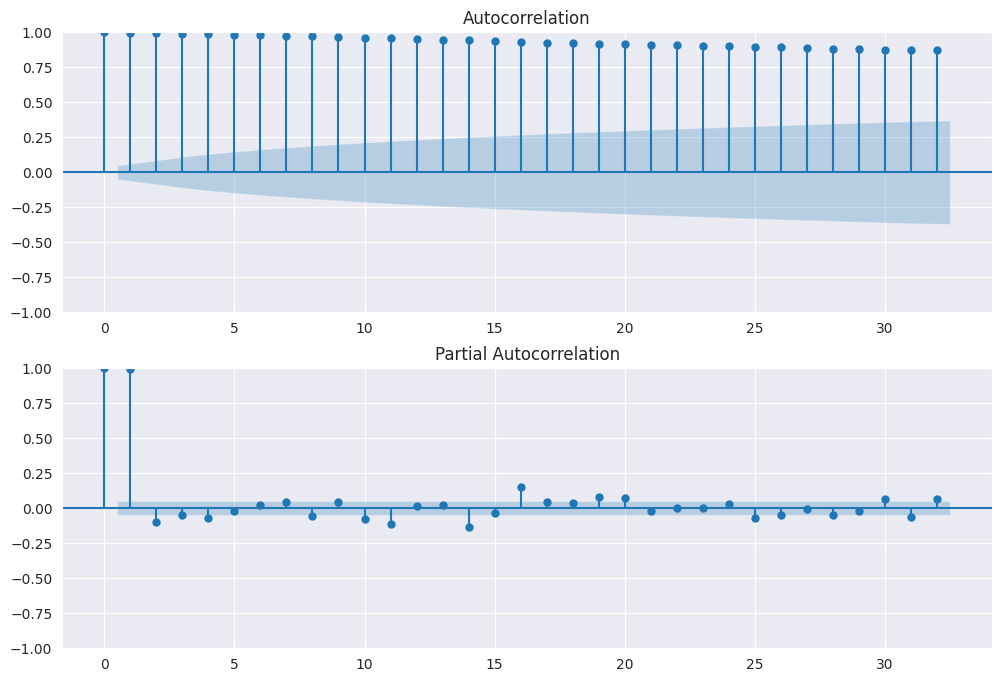

In [7]:
# Plotting the AutoCorrelation Function and Partial AutoCorrelation Function to determine ARIMA parameters.
fig, axes = plt.subplots(2, 1, figsize=(12,8))
plot_acf(df['Price'], ax=axes[0])
plot_pacf(df['Price'], ax=axes[1])
plt.show()

In [8]:
log_price = np.log(df['Price'])
log_diff = log_price.diff().dropna()

In [9]:
adf_test(log_diff, 'Stationarity')

Augmented Dickey-Fuller Test: Stationarity
ADF Test Statistic     -9.370754e+00
p-value                 7.388715e-16
# Lags used             1.800000e+01
# Observations          1.532000e+03
Critical Value (1%)    -3.434626e+00
Critical Value (5%)    -2.863428e+00
Critical Value (10%)   -2.567775e+00

Strong evidence against the null hypothesis,
Reject the null hypothesi,
 --> Data has no unit root and is STATIONARY


# **TRAIN-TEST SPLIT**

In [10]:
# Split the data into training and testing sets
train_size = int(0.8 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]

# **TRAINING PROCESSS**

In [11]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, start_p=1, start_q=1,
                   max_p=5, max_q=5, stationary=False,
                   start_P=0, seasonal=False,
                   d=1, D=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

# Fit an ARIMA model to the training data
model = ARIMA(train_data, order=(1, 1, 2))
model_fit = model.fit()

# Forecast the test_data
forecast = model_fit.forecast(steps=len(test_data))

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=21235.942, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21258.737, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21243.319, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21245.148, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21256.753, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=21237.932, Time=1.87 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=21237.956, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=21243.436, Time=0.39 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=21240.739, Time=0.40 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=21239.961, Time=0.94 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=21233.926, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=21243.158, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=21241.327, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=21235.918, Time=0.72 sec
 ARIMA(1,1,2)(0,0,0

# **PREDICTION**

In [12]:
### 1. Create sequence index
last_index =  df.index[-1]

# a) For 30 Days
last_data_30 = pd.RangeIndex(start = last_index, stop = last_index + 30, step = 1)

# b) For 60 Days
last_data_60 = pd.RangeIndex(start = last_index, stop = last_index + 60, step = 1)

# c) For 90 Days
last_data_90 = pd.RangeIndex(start = last_index, stop = last_index + 90, step = 1)


### 2. Create array

# a) Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)

# b) Create an array of 60 consecutive integers starting from last_index
x_next_60_days = np.array(range(last_index + 1, last_index + 61)).reshape(-1, 1)

# c) Create an array of 90 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index + 1, last_index + 91)).reshape(-1, 1)


### 3. Predict closing prices

# a) Predict the closing prices for the next 30 days
y_next_30_days = model_fit.forecast(steps=len(x_next_30_days))

# a) Predict the closing prices for the next 60 days
y_next_60_days = model_fit.forecast(steps=len(x_next_60_days))

# a) Predict the closing prices for the next 90 days
y_next_90_days = model_fit.forecast(steps=len(x_next_90_days))


### 4. Print result

# a) Print the predicted closing prices for the next 30 days
print('Predicted Closing Prices for the next 30 days:')
print(y_next_30_days)

# b) Print the predicted closing prices for the next 60 days
print('Predicted closing prices for the next 60 days:')
print(y_next_60_days[30:60])

# c) Print the predicted closing prices for the next 90 days
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days[60:90])

Predicted Closing Prices for the next 30 days:
1241    16588.609398
1242    16473.460805
1243    16395.498427
1244    16342.713305
1245    16306.974670
1246    16282.777509
1247    16266.394606
1248    16255.302416
1249    16247.792350
1250    16242.707593
1251    16239.264913
1252    16236.934016
1253    16235.355861
1254    16234.287358
1255    16233.563918
1256    16233.074107
1257    16232.742475
1258    16232.517942
1259    16232.365919
1260    16232.262991
1261    16232.193302
1262    16232.146119
1263    16232.114173
1264    16232.092544
1265    16232.077900
1266    16232.067985
1267    16232.061272
1268    16232.056727
1269    16232.053649
1270    16232.051566
Name: predicted_mean, dtype: float64
Predicted closing prices for the next 60 days:
1271    16232.050155
1272    16232.049200
1273    16232.048553
1274    16232.048116
1275    16232.047819
1276    16232.047618
1277    16232.047482
1278    16232.047390
1279    16232.047328
1280    16232.047286
1281    16232.047257
1282    

# **EVALUATION**

In [13]:
# Calculate performance metrics
test_mae = mean_absolute_error(test_data, forecast)
test_mape = mean_absolute_percentage_error(test_data, forecast)
test_rmse = sqrt(mean_squared_error(test_data, forecast))
test_mse = mean_squared_error(test_data, forecast)

# Calculate Mean Absolute Scaled Error (MASE)
naive_forecast = train_data.shift(1).dropna()
mase_denom = mean_absolute_error(train_data[1:], naive_forecast)
test_mase = test_mae / mase_denom

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)
print('MSE:', test_mse)
print('MASE:', test_mase)

MAE: 6650.144178847694
RMSE: 7727.038713618574
MAPE: 0.2801442764267236
MSE: 59707127.28176018
MASE: 10.26733690748832


# **VISUALIZATION**

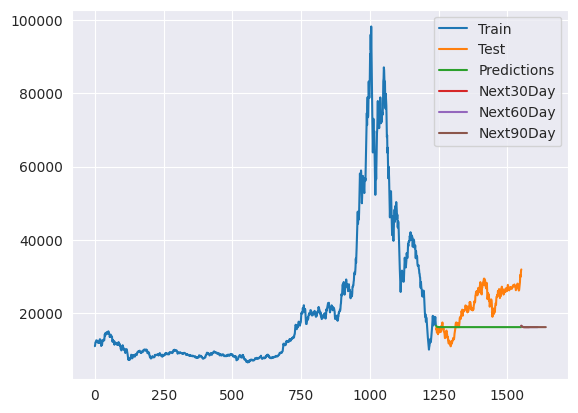

In [14]:
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, forecast)
plt.plot(last_data_30, y_next_30_days)
plt.plot(last_data_60, y_next_60_days)
plt.plot(last_data_90, y_next_90_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()

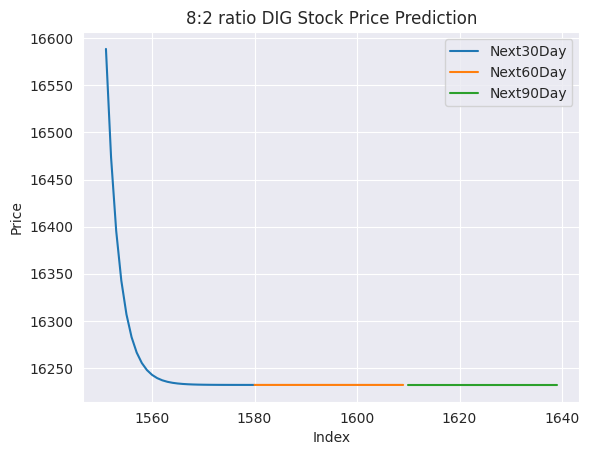

In [15]:
plt.plot(last_data_30, y_next_30_days)
plt.plot(range(last_data_30[-1], last_data_60[-1]), y_next_60_days[30:])
plt.plot(range(last_data_60[-1], last_data_90[-1]), y_next_90_days[60:])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])

# Adding labels and legend
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('8:2 ratio DIG Stock Price Prediction')
plt.legend(['Next30Day', 'Next60Day', 'Next90Day'])

plt.show()